In [1]:
import time
import argparse
import os
import matplotlib
from tqdm import tqdm

matplotlib.use('Agg')
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

from dataloader.dataloader_RGB import load_cisia_surf
# from data.dataloader_RGB_Depth import load_cisia_surf
# from dataloader.dataloader_RGB_Depth_IR import load_cisia_surf

from models.model_RGB import Model
# from models.model_RGB_Depth import Model
# from models.model_RGB_Depth_IR import Model

from loger import Logger
from evalution import eval_model
from centerloss import CenterLoss
from utils import plot_roc_curve, plot_eval_metric

In [2]:
time_object = time.localtime(time.time())
time_string = time.strftime('%Y-%m-%d_%I:%M_%p', time_object)
use_cuda = True if torch.cuda.is_available() else False

parser = argparse.ArgumentParser(description='face anti-spoofing test')
parser.add_argument('--batch-size', default='64', type=int, help='train batch size')
parser.add_argument('--test-size', default='64', type=int, help='test batch size')
parser.add_argument('--save-path', default='./logs/RGB/Test/', type=str, help='logs save path')
parser.add_argument('--message', default='', type=str, help='pretrained model checkpoint')
parser.add_argument('--mode', default=1, type=int, help='dataset protocol_mode')
args = parser.parse_known_args()[0]
print(args)

save_path = args.save_path + f'{time_string}' + '_' + f'{args.message}'

Namespace(batch_size=64, message='', mode=1, save_path='./logs/RGB/Test/', test_size=64)


In [3]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

# logger = Logger(f'{save_path}/logs.logs')
# logger.Print(args.message)

_, test_data = load_cisia_surf(train_size=args.batch_size,test_size=args.test_size, mode=args.mode)

eval_history = []
eval_loss = []
eval_score = []
test_score = []


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_dir = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/code/models/output/RGB/checkpoint_v'+ str(args.mode) +'_0/global_min_acer_model.pth'

model = Model(pretrained=False, num_classes=2)

if use_cuda:
    model = torch.nn.DataParallel(model,device_ids=list(range(torch.cuda.device_count()))) 
    model = model.cuda()
    model.load_state_dict(
        torch.load(global_dir))

In [29]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms 

train_transforms = transforms.Compose([
transforms.Resize((124,124)),
transforms.CenterCrop((90,90)),
# transforms.ToTensor(),
# transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
img = cv2.imread('bluebox.PNG')
img = Image.fromarray(img)
img = train_transforms(img)
img = np.array(img)
img = torch.tensor(img,dtype=torch.float32).to(device).unsqueeze(0).permute(0,3,1,2)
print(img.shape)
outputs, features = model(img)
_, pred_outputs = torch.max(outputs, 1)
prob_outputs = F.softmax(outputs,1)[:,1]

torch.Size([1, 3, 90, 90])


In [32]:
prob_outputs
# pred_outputs

tensor([0.8431], device='cuda:0', grad_fn=<SelectBackward0>)

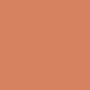

In [27]:
img

In [5]:
def val(epoch=0, data_set=test_data,flag=1, weight_dir=''):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Model(pretrained=False, num_classes=2)

    if use_cuda:
        model = torch.nn.DataParallel(model,device_ids=list(range(torch.cuda.device_count()))) 
        model = model.cuda()
        model.load_state_dict(
            torch.load(weight_dir))

    y_true = []
    y_pred = []
    y_prob = []
    
    model.eval()

    total_batch = 0
    
    with torch.no_grad():
        pbar = tqdm(enumerate(data_set, 1))
        for batch, data in pbar :
#             print(batch)

            rgb_img = data[0]
            labels = data[1]

            if use_cuda:
                rgb_img = rgb_img.cuda()
                labels = labels.cuda()

            print(rgb_img.shape)
            # 예측 오류 계산
            outputs, features = model(rgb_img)
            _, pred_outputs = torch.max(outputs, 1)
            prob_outputs = F.softmax(outputs,1)[:,1]

            y_true.extend(labels.data.cpu().numpy())
            y_pred.extend(pred_outputs.data.cpu().numpy())
            y_prob.extend(prob_outputs.data.cpu().numpy())

            total_batch = batch


    eval_result, score, acer = eval_model(y_true, y_pred, y_prob)
    eval_history.append(eval_result)

    plot_roc_curve(save_path, epoch, y_true, y_prob)
    plot_eval_metric(save_path, epoch, y_true, y_pred)

    if flag == 0 :
        eval_score.append(score)
        # avg_loss = total_loss/total_batch
        # eval_loss.append(avg_loss)
        # message = f'|eval|loss:{avg_loss:.6f}|'
        # logger.Print(message)
    else:
        test_score.append(score)

    return y_true,y_pred

In [6]:
global_dir = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/code/models/output/RGB/checkpoint_v'+ str(args.mode) +'_0/global_min_acer_model.pth'
print("--global_dir start--")
y_true,y_pred = val(epoch="_global_min", weight_dir=global_dir)

--global_dir start--


0it [00:00, ?it/s]

torch.Size([64, 3, 90, 90])


3it [00:02,  1.29it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


9it [00:03,  5.12it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


15it [00:03,  9.91it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


18it [00:03, 12.35it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


24it [00:03, 15.75it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


27it [00:04, 17.52it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


33it [00:04, 19.97it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])


39it [00:04, 21.60it/s]

torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([64, 3, 90, 90])
torch.Size([24, 3, 90, 90])


40it [00:04,  8.46it/s]


scikit learn AUC : 0.9966181657848324
auc_value: 0.9966181657848324


KeyboardInterrupt: 

In [84]:
import matplotlib.pyplot as plt
wrong_idx = [i for i in range(len(y_pred)) if y_pred[i]==0]
wrong_idx = [i for i in range(len(y_pred)) if y_true[i]==0]


In [5]:
rgb_paths = []
labels = []
metadata_root = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/code/metadata/'
data_root = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/data/'
datatxt='MakeTextFileCode_RGB/test_data_list.txt'
lines_in_txt = open(os.path.join(metadata_root, datatxt),'r')

for line in lines_in_txt:
    line = line.rstrip() 
    split_str = line.split()

    rgb_path = os.path.join(data_root, split_str[0])
    label = split_str[1] 
    rgb_paths.append(rgb_path)
    labels.append(label)

In [6]:
import cv2
from PIL import Image

In [86]:
for w in wrong_idx : 
    img = cv2.imread(rgb_paths[w])
#     plt.imshow(img)
#     plt.show()
    img2=Image.fromarray(img)
    display(img2)


In [7]:
rgb_paths[w]

NameError: name 'w' is not defined

In [77]:
img.shape

(253, 197, 3)

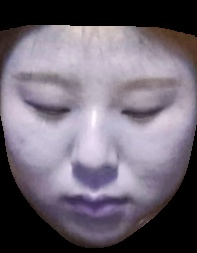

In [80]:
img2=Image.fromarray(img)
img2

In [6]:
from collections import Counter
Counter(y_true)

Counter({0: 1260, 1: 1260})

In [7]:
Counter(y_pred)

Counter({1: 2516, 0: 4})

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[   0, 1260],
       [   4, 1256]])

In [88]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

0.6652542372881356